# Import Packages

In [31]:
# built-in
from ast import literal_eval
import itertools
import os.path

# third-party (pip install required)
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import plot_expression
from scipy.stats import median_absolute_deviation
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [2]:
P1K_PATH = '../../data/precise1k/'
K12_PATH = '../../data/k12_modulome/'
FIG_PATH = 'investigate_expression_figs'
ANNOTATION_PATH = '../../data/annotation/'

In [17]:
ica_data = load_json_model(os.path.join(K12_PATH, 'k12_modulome.json.gz'))
log_tpm_p1k = pd.read_csv(os.path.join(P1K_PATH, 'log_tpm_qc.csv'), index_col=0)
log_tpm_k12 = pd.read_csv(os.path.join(K12_PATH, 'log_tpm_qc.csv'), index_col=0)
log_tpm = pd.concat([log_tpm_p1k, log_tpm_k12], axis=1, join='inner')

In [26]:
k12_sample_table = ica_data.sample_table

# PCA

In [19]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(log_tpm.T), index=log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T, index=log_tpm.index)

## Explained Variance

Number of dimensions for 95% of variance: 194


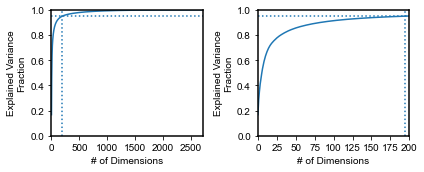

In [24]:
# Set the explained variance threshold
var_cutoff = 0.95

fig, (ax_all, ax_close) = plt.subplots(1, 2, figsize=(6,2.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax_all.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_all.vlines(dims,0,1,linestyles='dotted')
ax_all.hlines(var_cutoff,0,len(log_tpm.columns),linestyles='dotted')
ax_all.set_ylim(0,1)
ax_all.set_xlim(0,len(log_tpm.columns))
ax_all.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_all.set_xlabel('# of Dimensions',fontsize=10)
ax_all.set_xticks(np.arange(0, len(log_tpm.columns), 500))
for s in ax_all.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
ax_close.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_close.vlines(dims,0,1,linestyles='dotted')
ax_close.hlines(var_cutoff,0,len(log_tpm.columns),linestyles='dotted')
ax_close.set_ylim(0,1)
ax_close.set_xlim(0,200)
ax_close.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_close.set_xlabel('# of Dimensions',fontsize=10)
ax_close.set_xticks(np.arange(0, 220, 25))
for s in ax_close.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
print(f'Number of dimensions for {var_cutoff*100:.0f}% of variance:', dims)
plt.tight_layout()

## First 2 Components: By Study

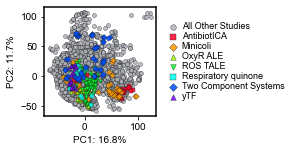

In [28]:
show_study = []
study_sort = []
for exp_id in k12_sample_table.index:
    if k12_sample_table.loc[exp_id, 'study'] in ['AntibiotICA', 'ROS TALE', 'Respiratory quinone',
                                           'Two Component Systems', 'yTF',                                         
                                          'Minicoli', 'OxyR ALE']:
        show_study.append(k12_sample_table.loc[exp_id, 'study'])
        study_sort.append(0)
    else:
        show_study.append('All Other Studies')
        study_sort.append(1)
        
k12_sample_table['show_study'] = show_study
k12_sample_table['study_sort'] = study_sort
k12_sample_table = k12_sample_table.sort_values(by = ['study_sort', 'show_study'], ascending = [False,True])

NUM_COLORS = len(k12_sample_table.groupby('show_study')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
marker_list = ["o", "s", "D", "^", "v","s", "D", "^", "v", "s", "D", "^", "v","s", "D", "^", "v"]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i,(name,group) in enumerate(k12_sample_table.groupby('show_study', sort=False)):
    idx = log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],marker=marker_list[i], s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)
plt.legend(bbox_to_anchor=(1,0.5),loc='center left',fontsize=9,ncol=1, markerscale=1.4, columnspacing=0.1, handletextpad=.01,
          frameon=False, labelspacing=0.11)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study.png'), dpi = 600, bbox_inches = 'tight')

# Gene Expression Breakdowns

## Load Gene Table

In [30]:
gene_table = pd.read_csv(os.path.join(ANNOTATION_PATH, 'gene_info.csv'), index_col=0)

### Add K12 Columns

In [38]:
gene_table_p1k = gene_table[gene_table['p1k']]
gene_table_p1k.head()

genes_in_im = []
for im in ica_data.imodulon_names:
    genes_in_im.extend(list(ica_data.view_imodulon(im).index))
genes_in_im = list(set(genes_in_im))

gene_table_p1k = gene_table_p1k.assign(
    in_k12_iM=gene_table_p1k.apply(lambda row: row.name in genes_in_im, axis=1),
    k12_median_log_tpm=log_tpm.median(axis=1).loc[gene_table_p1k.index],
    k12_mad_log_tpm=log_tpm.apply(median_absolute_deviation, axis=1).loc[gene_table_p1k.index]
)

## Statistical Comparisons

Running Mann-Whitney U tests for the medians of categories plotted below

In [39]:
cols = ['in_iM', 'iML1515', 'y_ome', 'proteomics', 'core_genome']

stats_df = pd.DataFrame(columns=['n_yes', 'n_no', 'U', 'P', 'U_mad', 'P_mad'])

for col in cols:
    yes_log_tpm_meds = gene_table_p1k[gene_table_p1k[col]]['p1k_median_log_tpm'].values
    no_log_tpm_meds = gene_table_p1k[~gene_table_p1k[col]]['p1k_median_log_tpm'].values
    n_yes = len(yes_log_tpm_meds)
    n_no = len(no_log_tpm_meds)
    U, p = mannwhitneyu(yes_log_tpm_meds, no_log_tpm_meds)
    yes_log_tpm_mads = gene_table_p1k[gene_table_p1k[col]]['p1k_mad_log_tpm'].values
    no_log_tpm_mads = gene_table_p1k[~gene_table_p1k[col]]['p1k_mad_log_tpm'].values
    U_mad, p_mad = mannwhitneyu(yes_log_tpm_mads, no_log_tpm_mads)
    stats_df.loc[col] = [n_yes, n_no, U, p, U_mad, p_mad]
    
stats_df

,n_yes,n_no,U,P,U_mad,P_mad
in_iM,2485.0,1772.0,2159090.0,2.809425e-01,3452234.5,1.172779e-219
iML1515,1511.0,2746.0,2400953.5,1.811482e-17,2239728.0,1.681583e-05
y_ome,1473.0,2784.0,1348073.0,1.052786e-75,2186367.5,3.652856e-04
proteomics,2031.0,2226.0,4010646.0,0.000000e+00,2237998.0,5.742013e-01
core_genome,356.0,3901.0,1178166.0,2.666801e-105,516214.0,1.007869e-15


## Function: plot_expression_by_boolean_category

In [44]:
sns.set_style('whitegrid')

def plot_jointgrid(genes, color, title, filename):
    g = sns.JointGrid(data=gene_table_p1k.loc[genes], x='k12_median_log_tpm',y='k12_mad_log_tpm',
                      xlim=(0, 15), ylim=(0, 4.5),
                      height=1.75, marginal_ticks=False)
    g.plot_joint(sns.histplot, color=color, bins=25)
    g.plot_marginals(sns.boxplot, color=color, fliersize=0.5, linewidth=0.5)

    g.ax_joint.set_xlabel('Median log[TPM]', fontsize=8)
    g.ax_joint.set_ylabel('MAD log[TPM]', fontsize=8)
    g.ax_joint.set_xticks(np.arange(0, 20, 5))
    for s in g.ax_joint.spines.values():
        s.set_visible(True)
        s.set_color('k')
        s.set_linewidth(0.9)
        
    g.ax_marg_x.set_title(f'{title} (n={len(genes)})', fontsize=10)

    for s in (list(g.ax_marg_x.spines.values()) + list(g.ax_marg_y.spines.values())):
        s.set_visible(False)
        
    plt.savefig(os.path.join(FIG_PATH, f'{filename}.png'), bbox_inches='tight', dpi=400)
    plt.savefig(os.path.join(FIG_PATH, f'{filename}.svg'), bbox_inches='tight', dpi=400)

def plot_expression_by_boolean_category(bool_col, filename_prefix, title_base, title_negate='not'):
    
    # get the yes/no genes from the category column
    yes_genes = gene_table_p1k[gene_table_p1k[bool_col]].index
    no_genes = gene_table_p1k[~gene_table_p1k[bool_col]].index
    
    plot_jointgrid(yes_genes, 'steelblue', title_base, f'{filename_prefix}_yes')
    plot_jointgrid(no_genes, 'firebrick', f'{title_negate} {title_base}', f'{filename_prefix}_no')

## iModulon Membership

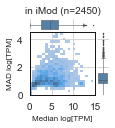

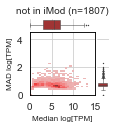

In [45]:
plot_expression_by_boolean_category('in_k12_iM', 'im_membership', 'in iMod')

## iML1515

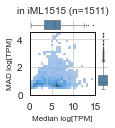

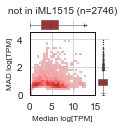

In [46]:
plot_expression_by_boolean_category('iML1515', 'iML1515', 'in iML1515')

## y-ome

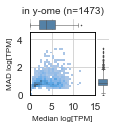

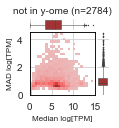

In [47]:
plot_expression_by_boolean_category('y_ome', 'y_ome', 'in y-ome')

### y-ome Fraction in iModulon

In [48]:
n_im_yome = gene_table_p1k[gene_table_p1k['in_iM'] & gene_table_p1k['y_ome']].shape[0]
n_yome = gene_table_p1k[gene_table_p1k['y_ome']].shape[0]
print(f'{n_im_yome}/{n_yome} ({n_im_yome/n_yome*100:.1f})% of y-ome in at least 1 iModulon')

823/1473 (55.9)% of y-ome in at least 1 iModulon


## Proteomics

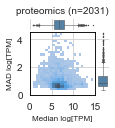

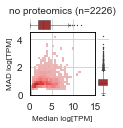

In [49]:
plot_expression_by_boolean_category('proteomics', 'proteomics', 'proteomics', title_negate='no')

## Core Genome

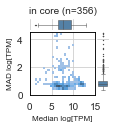

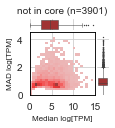

In [50]:
plot_expression_by_boolean_category('core_genome', 'core_genome', 'in core')

### by COG category

In [51]:
gene_table_p1k['COG'].value_counts()

Function unknown                                                    834
Transcription                                                       377
Amino acid transport and metabolism                                 311
Inorganic ion transport and metabolism                              305
Energy production and conversion                                    291
Cell wall/membrane/envelope biogenesis                              269
Translation, ribosomal structure and biogenesis                     244
Nucleotide transport and metabolism                                 242
Carbohydrate transport and metabolism                               239
Replication, recombination and repair                               228
No COG annotation                                                   160
Post-translational modification, protein turnover,and chaperones    123
Coenzyme transport and metabolism                                   122
Cell motility                                                   

In [52]:
gene_table_p1k[gene_table_p1k['core_genome']]['COG'].value_counts()

Translation, ribosomal structure and biogenesis                     152
Nucleotide transport and metabolism                                  41
Amino acid transport and metabolism                                  36
Coenzyme transport and metabolism                                    29
Lipid transport and metabolism                                       26
Energy production and conversion                                     18
Cell wall/membrane/envelope biogenesis                               16
Transcription                                                        14
Function unknown                                                      6
Post-translational modification, protein turnover,and chaperones      5
Inorganic ion transport and metabolism                                4
Carbohydrate transport and metabolism                                 2
Cell cycle control, cell division, chromosome partitioning            2
Intracellular trafficking, secretion, and vesicular transport   

## COG

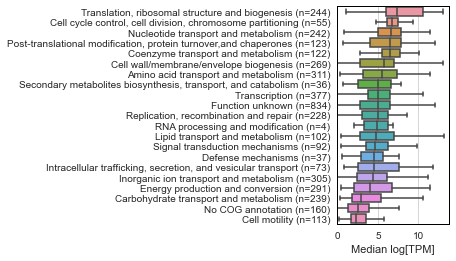

In [53]:
sns.set_style('whitegrid')
_, ax = plt.subplots(figsize=(2, 4))
sns.boxplot(y='COG', x='p1k_median_log_tpm', data=gene_table_p1k,
            order=gene_table_p1k.groupby('COG').median().sort_values('p1k_median_log_tpm', ascending=False).index,
            orient='h', showfliers=False,
           ax=ax)

ax.set_xlabel('Median log[TPM]', fontsize=11)
ax.set_ylabel('')
ax.set_xlim(0, ax.get_xlim()[1])
old_labs = [t.get_text() for t in ax.get_yticklabels()]
new_labs = [
    f"{cog} (n={gene_table_p1k[gene_table_p1k['COG'] == cog].shape[0]})"
    for cog in old_labs
]
ax.set_yticklabels(new_labs)

for s in ax.spines.values():
    s.set_linewidth(1)
    s.set_color('k')
    
plt.savefig(os.path.join(FIG_PATH, 'by_cog.png'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'by_cog.svg'), bbox_inches='tight', dpi=400)